<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_driven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [4]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [19]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [20]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)
ITdataloader_test = DataLoader(SpikeData(stimulus_test,spike = None), batch_size=64, shuffle=False)

In [7]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [8]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                optimizer.zero_grad()

                outputs = model(stimulus)
                loss = criterion(outputs, spikes)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)
    return model

In [82]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.MSELoss()
model = ShallowCNN(num_neuron=168)
model.apply(ShallowCNN.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=200, scheduler=None)

save_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
torch.save(model.state_dict(), save_path)

Epoch 1/200: 100%|██████████| 41/41 [00:02<00:00, 17.90it/s, loss=1.19e+3]


Epoch [1/200], Train Loss: 1186.8986
Validation Loss: 53.2870


Epoch 2/200: 100%|██████████| 41/41 [00:02<00:00, 17.88it/s, loss=51.7]


Epoch [2/200], Train Loss: 51.6516
Validation Loss: 15.7269


Epoch 3/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=28.9]


Epoch [3/200], Train Loss: 28.8769
Validation Loss: 11.6456


Epoch 4/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=21.6]


Epoch [4/200], Train Loss: 21.5626
Validation Loss: 9.2716


Epoch 5/200: 100%|██████████| 41/41 [00:02<00:00, 17.87it/s, loss=16.6]


Epoch [5/200], Train Loss: 16.6418
Validation Loss: 7.9406


Epoch 6/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=13.7]


Epoch [6/200], Train Loss: 13.6786
Validation Loss: 6.5435


Epoch 7/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=11.9]


Epoch [7/200], Train Loss: 11.8514
Validation Loss: 5.8823


Epoch 8/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=10.3]


Epoch [8/200], Train Loss: 10.3499
Validation Loss: 5.1814


Epoch 9/200: 100%|██████████| 41/41 [00:02<00:00, 17.87it/s, loss=8.63]


Epoch [9/200], Train Loss: 8.6262
Validation Loss: 4.8200


Epoch 10/200: 100%|██████████| 41/41 [00:02<00:00, 17.86it/s, loss=7.86]


Epoch [10/200], Train Loss: 7.8556
Validation Loss: 4.5379


Epoch 11/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=7.28]


Epoch [11/200], Train Loss: 7.2773
Validation Loss: 4.0179


Epoch 12/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=6.51]


Epoch [12/200], Train Loss: 6.5081
Validation Loss: 3.6206


Epoch 13/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=5.87]


Epoch [13/200], Train Loss: 5.8708
Validation Loss: 3.5659


Epoch 14/200: 100%|██████████| 41/41 [00:02<00:00, 17.88it/s, loss=5.59]


Epoch [14/200], Train Loss: 5.5912
Validation Loss: 3.1243


Epoch 15/200: 100%|██████████| 41/41 [00:02<00:00, 17.82it/s, loss=5.14]


Epoch [15/200], Train Loss: 5.1352
Validation Loss: 3.1694


Epoch 16/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=4.89]


Epoch [16/200], Train Loss: 4.8859
Validation Loss: 3.0005


Epoch 17/200: 100%|██████████| 41/41 [00:02<00:00, 17.87it/s, loss=4.56]


Epoch [17/200], Train Loss: 4.5575
Validation Loss: 2.7466


Epoch 18/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=4.25]


Epoch [18/200], Train Loss: 4.2531
Validation Loss: 2.6010


Epoch 19/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=4.03]


Epoch [19/200], Train Loss: 4.0304
Validation Loss: 2.5610


Epoch 20/200: 100%|██████████| 41/41 [00:02<00:00, 17.86it/s, loss=3.82]


Epoch [20/200], Train Loss: 3.8220
Validation Loss: 2.5832


Epoch 21/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=3.69]


Epoch [21/200], Train Loss: 3.6907
Validation Loss: 2.5071


Epoch 22/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=3.47]


Epoch [22/200], Train Loss: 3.4727
Validation Loss: 2.3434


Epoch 23/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=3.29]


Epoch [23/200], Train Loss: 3.2939
Validation Loss: 2.3051


Epoch 24/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=3.16]


Epoch [24/200], Train Loss: 3.1630
Validation Loss: 2.2873


Epoch 25/200: 100%|██████████| 41/41 [00:02<00:00, 17.87it/s, loss=3.13]


Epoch [25/200], Train Loss: 3.1323
Validation Loss: 2.2370


Epoch 26/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=2.94]


Epoch [26/200], Train Loss: 2.9362
Validation Loss: 2.1287


Epoch 27/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=2.91]


Epoch [27/200], Train Loss: 2.9142
Validation Loss: 2.1204


Epoch 28/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=2.82]


Epoch [28/200], Train Loss: 2.8198
Validation Loss: 2.0372


Epoch 29/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=2.76]


Epoch [29/200], Train Loss: 2.7643
Validation Loss: 2.0184


Epoch 30/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=2.67]


Epoch [30/200], Train Loss: 2.6687
Validation Loss: 2.0621


Epoch 31/200: 100%|██████████| 41/41 [00:02<00:00, 18.07it/s, loss=2.53]


Epoch [31/200], Train Loss: 2.5265
Validation Loss: 1.8857


Epoch 32/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=2.41]


Epoch [32/200], Train Loss: 2.4137
Validation Loss: 1.8599


Epoch 33/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=2.38]


Epoch [33/200], Train Loss: 2.3758
Validation Loss: 1.8315


Epoch 34/200: 100%|██████████| 41/41 [00:02<00:00, 17.88it/s, loss=2.33]


Epoch [34/200], Train Loss: 2.3251
Validation Loss: 1.7887


Epoch 35/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=2.27]


Epoch [35/200], Train Loss: 2.2678
Validation Loss: 1.8514


Epoch 36/200: 100%|██████████| 41/41 [00:02<00:00, 18.07it/s, loss=2.29]


Epoch [36/200], Train Loss: 2.2876
Validation Loss: 1.7391


Epoch 37/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=2.11]


Epoch [37/200], Train Loss: 2.1118
Validation Loss: 1.7067


Epoch 38/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=2.26]


Epoch [38/200], Train Loss: 2.2644
Validation Loss: 1.7549


Epoch 39/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=2.15]


Epoch [39/200], Train Loss: 2.1465
Validation Loss: 1.7372


Epoch 40/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=2.04]


Epoch [40/200], Train Loss: 2.0367
Validation Loss: 1.6669


Epoch 41/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=2]


Epoch [41/200], Train Loss: 2.0035
Validation Loss: 1.6472


Epoch 42/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.97]


Epoch [42/200], Train Loss: 1.9732
Validation Loss: 1.6790


Epoch 43/200: 100%|██████████| 41/41 [00:02<00:00, 18.04it/s, loss=1.98]


Epoch [43/200], Train Loss: 1.9769
Validation Loss: 1.5634


Epoch 44/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=1.88]


Epoch [44/200], Train Loss: 1.8770
Validation Loss: 1.5006


Epoch 45/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.95]


Epoch [45/200], Train Loss: 1.9503
Validation Loss: 1.5011


Epoch 46/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.81]


Epoch [46/200], Train Loss: 1.8065
Validation Loss: 1.4677


Epoch 47/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.78]


Epoch [47/200], Train Loss: 1.7794
Validation Loss: 1.5023


Epoch 48/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.77]


Epoch [48/200], Train Loss: 1.7740
Validation Loss: 1.5295


Epoch 49/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.72]


Epoch [49/200], Train Loss: 1.7168
Validation Loss: 1.4448


Epoch 50/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.69]


Epoch [50/200], Train Loss: 1.6878
Validation Loss: 1.4068


Epoch 51/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=1.73]


Epoch [51/200], Train Loss: 1.7262
Validation Loss: 1.4173


Epoch 52/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.65]


Epoch [52/200], Train Loss: 1.6492
Validation Loss: 1.3745


Epoch 53/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.6]


Epoch [53/200], Train Loss: 1.6037
Validation Loss: 1.3902


Epoch 54/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.6]


Epoch [54/200], Train Loss: 1.6010
Validation Loss: 1.4248


Epoch 55/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.6]


Epoch [55/200], Train Loss: 1.5992
Validation Loss: 1.4039


Epoch 56/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.53]


Epoch [56/200], Train Loss: 1.5323
Validation Loss: 1.3427


Epoch 57/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.59]


Epoch [57/200], Train Loss: 1.5910
Validation Loss: 1.3789


Epoch 58/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=1.56]


Epoch [58/200], Train Loss: 1.5631
Validation Loss: 1.3327


Epoch 59/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.47]


Epoch [59/200], Train Loss: 1.4745
Validation Loss: 1.3371


Epoch 60/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.44]


Epoch [60/200], Train Loss: 1.4430
Validation Loss: 1.2629


Epoch 61/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.52]


Epoch [61/200], Train Loss: 1.5208
Validation Loss: 1.3169


Epoch 62/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.48]


Epoch [62/200], Train Loss: 1.4808
Validation Loss: 1.3032


Epoch 63/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.48]


Epoch [63/200], Train Loss: 1.4827
Validation Loss: 1.2763


Epoch 64/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.51]


Epoch [64/200], Train Loss: 1.5052
Validation Loss: 1.2980


Epoch 65/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.43]


Epoch [65/200], Train Loss: 1.4269
Validation Loss: 1.2434


Epoch 66/200: 100%|██████████| 41/41 [00:02<00:00, 18.06it/s, loss=1.42]


Epoch [66/200], Train Loss: 1.4196
Validation Loss: 1.3898


Epoch 67/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.45]


Epoch [67/200], Train Loss: 1.4523
Validation Loss: 1.2631


Epoch 68/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.35]


Epoch [68/200], Train Loss: 1.3550
Validation Loss: 1.2051


Epoch 69/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=1.31]


Epoch [69/200], Train Loss: 1.3063
Validation Loss: 1.2101


Epoch 70/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.31]


Epoch [70/200], Train Loss: 1.3100
Validation Loss: 1.2044


Epoch 71/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.31]


Epoch [71/200], Train Loss: 1.3136
Validation Loss: 1.2147


Epoch 72/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=1.29]


Epoch [72/200], Train Loss: 1.2937
Validation Loss: 1.2049


Epoch 73/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.27]


Epoch [73/200], Train Loss: 1.2709
Validation Loss: 1.2031


Epoch 74/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.27]


Epoch [74/200], Train Loss: 1.2712
Validation Loss: 1.1760


Epoch 75/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=1.23]


Epoch [75/200], Train Loss: 1.2334
Validation Loss: 1.1605


Epoch 76/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.26]


Epoch [76/200], Train Loss: 1.2649
Validation Loss: 1.2267


Epoch 77/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=1.25]


Epoch [77/200], Train Loss: 1.2528
Validation Loss: 1.1623


Epoch 78/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=1.25]


Epoch [78/200], Train Loss: 1.2511
Validation Loss: 1.1706


Epoch 79/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.21]


Epoch [79/200], Train Loss: 1.2099
Validation Loss: 1.1363


Epoch 80/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.22]


Epoch [80/200], Train Loss: 1.2219
Validation Loss: 1.1325


Epoch 81/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=1.21]


Epoch [81/200], Train Loss: 1.2136
Validation Loss: 1.1370


Epoch 82/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.19]


Epoch [82/200], Train Loss: 1.1860
Validation Loss: 1.1245


Epoch 83/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.17]


Epoch [83/200], Train Loss: 1.1744
Validation Loss: 1.1226


Epoch 84/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.16]


Epoch [84/200], Train Loss: 1.1590
Validation Loss: 1.1425


Epoch 85/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=1.19]


Epoch [85/200], Train Loss: 1.1950
Validation Loss: 1.1142


Epoch 86/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.18]


Epoch [86/200], Train Loss: 1.1757
Validation Loss: 1.0952


Epoch 87/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.17]


Epoch [87/200], Train Loss: 1.1662
Validation Loss: 1.1018


Epoch 88/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.18]


Epoch [88/200], Train Loss: 1.1762
Validation Loss: 1.1220


Epoch 89/200: 100%|██████████| 41/41 [00:02<00:00, 18.06it/s, loss=1.15]


Epoch [89/200], Train Loss: 1.1498
Validation Loss: 1.0909


Epoch 90/200: 100%|██████████| 41/41 [00:02<00:00, 17.90it/s, loss=1.13]


Epoch [90/200], Train Loss: 1.1282
Validation Loss: 1.1189


Epoch 91/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.14]


Epoch [91/200], Train Loss: 1.1382
Validation Loss: 1.0689


Epoch 92/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=1.12]


Epoch [92/200], Train Loss: 1.1238
Validation Loss: 1.0845


Epoch 93/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.11]


Epoch [93/200], Train Loss: 1.1141
Validation Loss: 1.0848


Epoch 94/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.13]


Epoch [94/200], Train Loss: 1.1290
Validation Loss: 1.0715


Epoch 95/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.12]


Epoch [95/200], Train Loss: 1.1196
Validation Loss: 1.1249


Epoch 96/200: 100%|██████████| 41/41 [00:02<00:00, 17.87it/s, loss=1.11]


Epoch [96/200], Train Loss: 1.1123
Validation Loss: 1.0643


Epoch 97/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=1.07]


Epoch [97/200], Train Loss: 1.0744
Validation Loss: 1.0576


Epoch 98/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=1.09]


Epoch [98/200], Train Loss: 1.0857
Validation Loss: 1.0718


Epoch 99/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=1.08]


Epoch [99/200], Train Loss: 1.0802
Validation Loss: 1.0423


Epoch 100/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=1.06]


Epoch [100/200], Train Loss: 1.0585
Validation Loss: 1.0377


Epoch 101/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=1.06]


Epoch [101/200], Train Loss: 1.0605
Validation Loss: 1.0319


Epoch 102/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=1.07]


Epoch [102/200], Train Loss: 1.0650
Validation Loss: 1.0302


Epoch 103/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.05]


Epoch [103/200], Train Loss: 1.0476
Validation Loss: 1.0329


Epoch 104/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.05]


Epoch [104/200], Train Loss: 1.0479
Validation Loss: 1.0255


Epoch 105/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=1.05]


Epoch [105/200], Train Loss: 1.0474
Validation Loss: 1.0280


Epoch 106/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=1.05]


Epoch [106/200], Train Loss: 1.0547
Validation Loss: 1.0364


Epoch 107/200: 100%|██████████| 41/41 [00:02<00:00, 18.04it/s, loss=1.04]


Epoch [107/200], Train Loss: 1.0390
Validation Loss: 1.0351


Epoch 108/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.05]


Epoch [108/200], Train Loss: 1.0475
Validation Loss: 1.0219


Epoch 109/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=1.03]


Epoch [109/200], Train Loss: 1.0301
Validation Loss: 1.0274


Epoch 110/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=1.01]


Epoch [110/200], Train Loss: 1.0146
Validation Loss: 1.0179


Epoch 111/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=1.02]


Epoch [111/200], Train Loss: 1.0194
Validation Loss: 1.0043


Epoch 112/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=1.03]


Epoch [112/200], Train Loss: 1.0265
Validation Loss: 1.0196


Epoch 113/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=1.03]


Epoch [113/200], Train Loss: 1.0265
Validation Loss: 1.0181


Epoch 114/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.01]


Epoch [114/200], Train Loss: 1.0086
Validation Loss: 0.9971


Epoch 115/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=1.02]


Epoch [115/200], Train Loss: 1.0183
Validation Loss: 0.9896


Epoch 116/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=0.997]


Epoch [116/200], Train Loss: 0.9965
Validation Loss: 0.9925


Epoch 117/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.998]


Epoch [117/200], Train Loss: 0.9983
Validation Loss: 1.0020


Epoch 118/200: 100%|██████████| 41/41 [00:02<00:00, 18.04it/s, loss=1.01]


Epoch [118/200], Train Loss: 1.0077
Validation Loss: 1.0263


Epoch 119/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=1.01]


Epoch [119/200], Train Loss: 1.0095
Validation Loss: 0.9906


Epoch 120/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.985]


Epoch [120/200], Train Loss: 0.9854
Validation Loss: 0.9747


Epoch 121/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.975]


Epoch [121/200], Train Loss: 0.9751
Validation Loss: 0.9742


Epoch 122/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.976]


Epoch [122/200], Train Loss: 0.9756
Validation Loss: 1.0241


Epoch 123/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.985]


Epoch [123/200], Train Loss: 0.9849
Validation Loss: 0.9866


Epoch 124/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.972]


Epoch [124/200], Train Loss: 0.9721
Validation Loss: 0.9727


Epoch 125/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.974]


Epoch [125/200], Train Loss: 0.9738
Validation Loss: 0.9671


Epoch 126/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.96]


Epoch [126/200], Train Loss: 0.9602
Validation Loss: 0.9794


Epoch 127/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.977]


Epoch [127/200], Train Loss: 0.9768
Validation Loss: 0.9795


Epoch 128/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.979]


Epoch [128/200], Train Loss: 0.9786
Validation Loss: 0.9776


Epoch 129/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.982]


Epoch [129/200], Train Loss: 0.9816
Validation Loss: 0.9654


Epoch 130/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.955]


Epoch [130/200], Train Loss: 0.9550
Validation Loss: 0.9582


Epoch 131/200: 100%|██████████| 41/41 [00:02<00:00, 18.06it/s, loss=0.952]


Epoch [131/200], Train Loss: 0.9519
Validation Loss: 0.9476


Epoch 132/200: 100%|██████████| 41/41 [00:02<00:00, 18.04it/s, loss=0.946]


Epoch [132/200], Train Loss: 0.9457
Validation Loss: 0.9505


Epoch 133/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.956]


Epoch [133/200], Train Loss: 0.9561
Validation Loss: 1.0300


Epoch 134/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.952]


Epoch [134/200], Train Loss: 0.9521
Validation Loss: 0.9439


Epoch 135/200: 100%|██████████| 41/41 [00:02<00:00, 17.90it/s, loss=0.935]


Epoch [135/200], Train Loss: 0.9354
Validation Loss: 0.9384


Epoch 136/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=0.952]


Epoch [136/200], Train Loss: 0.9520
Validation Loss: 0.9722


Epoch 137/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.963]


Epoch [137/200], Train Loss: 0.9633
Validation Loss: 0.9450


Epoch 138/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.93]


Epoch [138/200], Train Loss: 0.9297
Validation Loss: 0.9566


Epoch 139/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=0.933]


Epoch [139/200], Train Loss: 0.9329
Validation Loss: 0.9285


Epoch 140/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.932]


Epoch [140/200], Train Loss: 0.9320
Validation Loss: 0.9305


Epoch 141/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.924]


Epoch [141/200], Train Loss: 0.9242
Validation Loss: 0.9340


Epoch 142/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.926]


Epoch [142/200], Train Loss: 0.9263
Validation Loss: 0.9272


Epoch 143/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.917]


Epoch [143/200], Train Loss: 0.9173
Validation Loss: 0.9174


Epoch 144/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.923]


Epoch [144/200], Train Loss: 0.9226
Validation Loss: 0.9337


Epoch 145/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.925]


Epoch [145/200], Train Loss: 0.9248
Validation Loss: 0.9386


Epoch 146/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.91]


Epoch [146/200], Train Loss: 0.9095
Validation Loss: 0.9241


Epoch 147/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.912]


Epoch [147/200], Train Loss: 0.9118
Validation Loss: 0.9175


Epoch 148/200: 100%|██████████| 41/41 [00:02<00:00, 17.92it/s, loss=0.917]


Epoch [148/200], Train Loss: 0.9170
Validation Loss: 0.9462


Epoch 149/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=0.908]


Epoch [149/200], Train Loss: 0.9085
Validation Loss: 0.9168


Epoch 150/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.902]


Epoch [150/200], Train Loss: 0.9018
Validation Loss: 0.9100


Epoch 151/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=0.904]


Epoch [151/200], Train Loss: 0.9045
Validation Loss: 0.9176


Epoch 152/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.9]


Epoch [152/200], Train Loss: 0.9003
Validation Loss: 0.9281


Epoch 153/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.894]


Epoch [153/200], Train Loss: 0.8935
Validation Loss: 0.9017


Epoch 154/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.89]


Epoch [154/200], Train Loss: 0.8898
Validation Loss: 0.9053


Epoch 155/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.887]


Epoch [155/200], Train Loss: 0.8869
Validation Loss: 0.9021


Epoch 156/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=0.889]


Epoch [156/200], Train Loss: 0.8893
Validation Loss: 0.8904


Epoch 157/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.887]


Epoch [157/200], Train Loss: 0.8874
Validation Loss: 0.8911


Epoch 158/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.88]


Epoch [158/200], Train Loss: 0.8799
Validation Loss: 0.8932


Epoch 159/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.89]


Epoch [159/200], Train Loss: 0.8899
Validation Loss: 0.9423


Epoch 160/200: 100%|██████████| 41/41 [00:02<00:00, 17.90it/s, loss=0.887]


Epoch [160/200], Train Loss: 0.8871
Validation Loss: 0.8929


Epoch 161/200: 100%|██████████| 41/41 [00:02<00:00, 17.88it/s, loss=0.886]


Epoch [161/200], Train Loss: 0.8859
Validation Loss: 0.8798


Epoch 162/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=0.87]


Epoch [162/200], Train Loss: 0.8697
Validation Loss: 0.8831


Epoch 163/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=0.874]


Epoch [163/200], Train Loss: 0.8744
Validation Loss: 0.8832


Epoch 164/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.869]


Epoch [164/200], Train Loss: 0.8694
Validation Loss: 0.8791


Epoch 165/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=0.869]


Epoch [165/200], Train Loss: 0.8694
Validation Loss: 0.8774


Epoch 166/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.859]


Epoch [166/200], Train Loss: 0.8591
Validation Loss: 0.8751


Epoch 167/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.855]


Epoch [167/200], Train Loss: 0.8551
Validation Loss: 0.8752


Epoch 168/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=0.862]


Epoch [168/200], Train Loss: 0.8622
Validation Loss: 0.8839


Epoch 169/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.86]


Epoch [169/200], Train Loss: 0.8601
Validation Loss: 0.9085


Epoch 170/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=0.854]


Epoch [170/200], Train Loss: 0.8542
Validation Loss: 0.8759


Epoch 171/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=0.857]


Epoch [171/200], Train Loss: 0.8566
Validation Loss: 0.8567


Epoch 172/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.843]


Epoch [172/200], Train Loss: 0.8433
Validation Loss: 0.8674


Epoch 173/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.836]


Epoch [173/200], Train Loss: 0.8365
Validation Loss: 0.9243


Epoch 174/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.854]


Epoch [174/200], Train Loss: 0.8542
Validation Loss: 0.8977


Epoch 175/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=0.843]


Epoch [175/200], Train Loss: 0.8432
Validation Loss: 0.8699


Epoch 176/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.831]


Epoch [176/200], Train Loss: 0.8309
Validation Loss: 0.8465


Epoch 177/200: 100%|██████████| 41/41 [00:02<00:00, 18.00it/s, loss=0.836]


Epoch [177/200], Train Loss: 0.8363
Validation Loss: 0.8586


Epoch 178/200: 100%|██████████| 41/41 [00:02<00:00, 17.93it/s, loss=0.83]


Epoch [178/200], Train Loss: 0.8305
Validation Loss: 0.8544


Epoch 179/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.833]


Epoch [179/200], Train Loss: 0.8327
Validation Loss: 0.8871


Epoch 180/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.824]


Epoch [180/200], Train Loss: 0.8244
Validation Loss: 0.8593


Epoch 181/200: 100%|██████████| 41/41 [00:02<00:00, 17.91it/s, loss=0.826]


Epoch [181/200], Train Loss: 0.8264
Validation Loss: 0.8526


Epoch 182/200: 100%|██████████| 41/41 [00:02<00:00, 17.96it/s, loss=0.827]


Epoch [182/200], Train Loss: 0.8274
Validation Loss: 0.8311


Epoch 183/200: 100%|██████████| 41/41 [00:02<00:00, 18.03it/s, loss=0.825]


Epoch [183/200], Train Loss: 0.8246
Validation Loss: 0.9163


Epoch 184/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=0.817]


Epoch [184/200], Train Loss: 0.8175
Validation Loss: 0.9022


Epoch 185/200: 100%|██████████| 41/41 [00:02<00:00, 17.95it/s, loss=0.818]


Epoch [185/200], Train Loss: 0.8178
Validation Loss: 0.8332


Epoch 186/200: 100%|██████████| 41/41 [00:02<00:00, 17.85it/s, loss=0.808]


Epoch [186/200], Train Loss: 0.8078
Validation Loss: 0.8436


Epoch 187/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.811]


Epoch [187/200], Train Loss: 0.8109
Validation Loss: 0.8223


Epoch 188/200: 100%|██████████| 41/41 [00:02<00:00, 17.99it/s, loss=0.808]


Epoch [188/200], Train Loss: 0.8083
Validation Loss: 0.8125


Epoch 189/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.809]


Epoch [189/200], Train Loss: 0.8089
Validation Loss: 0.8362


Epoch 190/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.812]


Epoch [190/200], Train Loss: 0.8117
Validation Loss: 0.8216


Epoch 191/200: 100%|██████████| 41/41 [00:02<00:00, 17.89it/s, loss=0.806]


Epoch [191/200], Train Loss: 0.8064
Validation Loss: 0.8252


Epoch 192/200: 100%|██████████| 41/41 [00:02<00:00, 18.04it/s, loss=0.801]


Epoch [192/200], Train Loss: 0.8013
Validation Loss: 0.8917


Epoch 193/200: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s, loss=0.791]


Epoch [193/200], Train Loss: 0.7913
Validation Loss: 0.8167


Epoch 194/200: 100%|██████████| 41/41 [00:02<00:00, 18.02it/s, loss=0.794]


Epoch [194/200], Train Loss: 0.7936
Validation Loss: 0.8889


Epoch 195/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.796]


Epoch [195/200], Train Loss: 0.7960
Validation Loss: 0.8115


Epoch 196/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.794]


Epoch [196/200], Train Loss: 0.7940
Validation Loss: 0.8530


Epoch 197/200: 100%|██████████| 41/41 [00:02<00:00, 18.06it/s, loss=0.795]


Epoch [197/200], Train Loss: 0.7948
Validation Loss: 0.9301


Epoch 198/200: 100%|██████████| 41/41 [00:02<00:00, 17.97it/s, loss=0.795]


Epoch [198/200], Train Loss: 0.7954
Validation Loss: 1.0634


Epoch 199/200: 100%|██████████| 41/41 [00:02<00:00, 17.98it/s, loss=0.788]


Epoch [199/200], Train Loss: 0.7881
Validation Loss: 0.9263


Epoch 200/200: 100%|██████████| 41/41 [00:02<00:00, 17.94it/s, loss=0.791]


Epoch [200/200], Train Loss: 0.7912
Validation Loss: 0.8422


In [9]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
model = ShallowCNN(num_neuron=168)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [10]:
model.eval()

prediction_train = []

ITdataloader_train2 = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train2:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)
prediction_train.shape

torch.Size([2592, 168])

In [11]:
model.eval()

prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)
prediction_val.shape

torch.Size([288, 168])

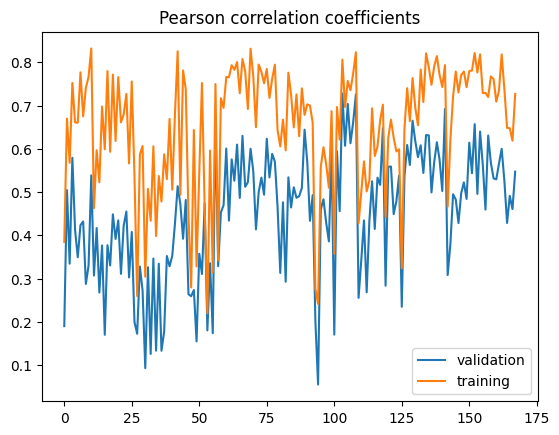

Pearson correlation on training set: 0.6529552393890089
Pearson correlation on validation set: 0.4503878191236212


<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_shallowcnn = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_shallowcnn[i,0] = np.corrcoef(spikes_train[:, i],prediction_train[:, i])[0, 1]
    pearson_corr_shallowcnn[i,1] = np.corrcoef(spikes_val[:, i],prediction_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_shallowcnn[:,1], label='validation')
plt.plot(pearson_corr_shallowcnn[:,0], label='training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_shallowcnn[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_shallowcnn[:,1])}")

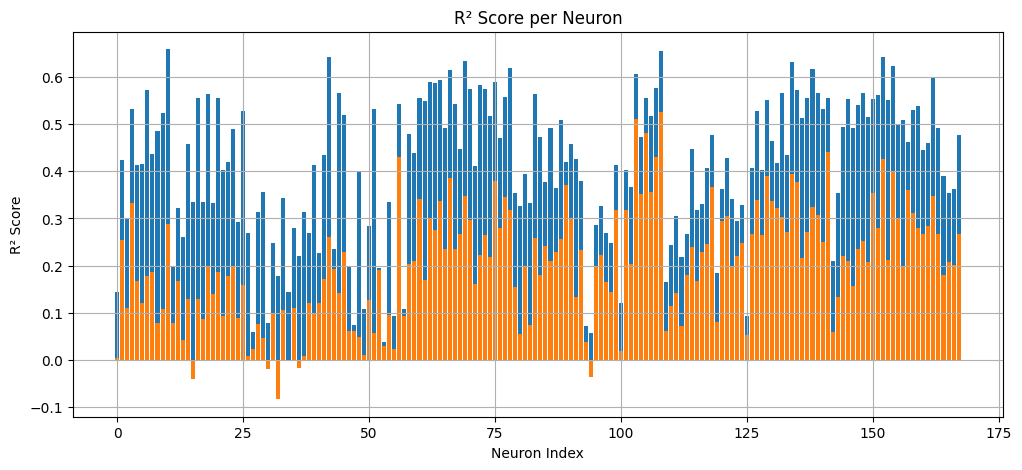

In [13]:
from sklearn.metrics import r2_score

r2_train = [r2_score(spikes_train[:, i], prediction_train[:, i]) for i in range(spikes_train.shape[1])]
r2_val = [r2_score(spikes_val[:, i], prediction_val[:, i]) for i in range(spikes_val.shape[1])]

plt.figure(figsize=(12, 5))
plt.bar(range(len(r2_train)), r2_train)
plt.bar(range(len(r2_val)), r2_val)
plt.xlabel('Neuron Index')
plt.ylabel('R² Score')
plt.title('R² Score per Neuron')
plt.grid(True)
plt.show()

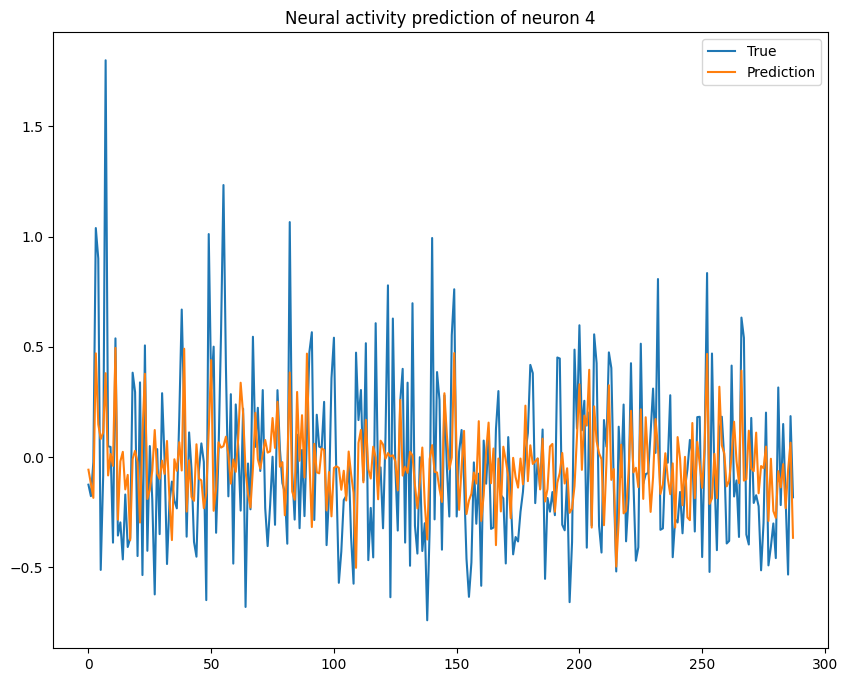

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in validation set')
plt.plot(spikes_val[:,example_id], label = "True")
plt.plot(prediction_val[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()

In [18]:
ITdataloader_test.dataset.stimulus

tensor([[[[0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          ...,
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741]],

         [[0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          ...,
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052]],

         [[0.4265, 0.4265, 0.4265,  ..., 0.4265, 0.4265, 0.4265],
          [0.4265, 0.4265, 0.4265,  ..., 0.4265, 0.4265, 0.4265],
          [0.4265, 0.4265, 0.4265,  ..., 0

In [23]:
model.eval()

prediction_test = []

with torch.no_grad():
    for stimulus in ITdataloader_test:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_test.append(outputs.cpu())

prediction_test = torch.cat(prediction_test, dim=0)
prediction_test.shape

torch.Size([320, 168])

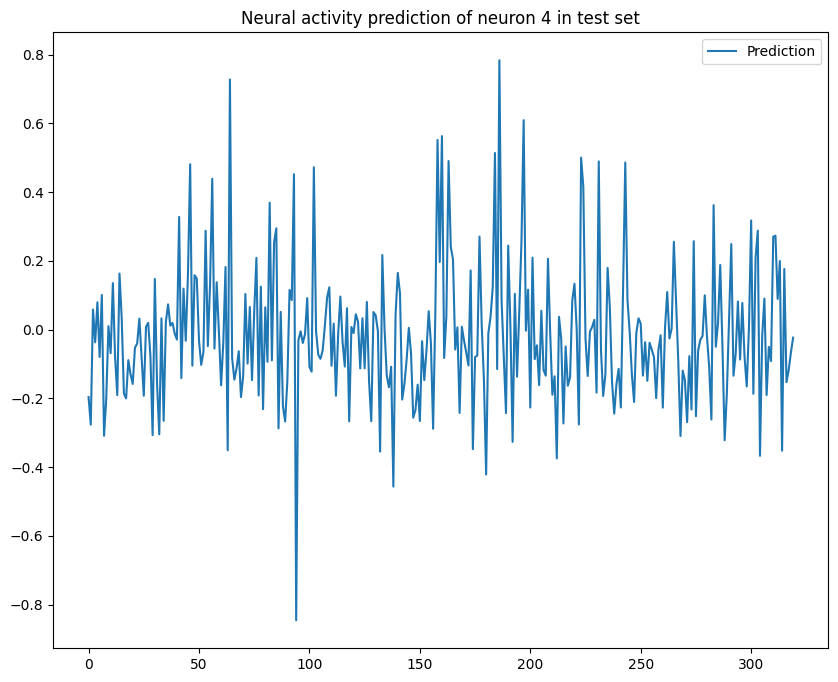

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in test set')
plt.plot(prediction_test[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()